### **Import libraries**

In [ ]:
!pip install contractions

     |████████████████████████████████| 321 kB 8.3 MB/s 
     |████████████████████████████████| 284 kB 41.3 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=7dfd55e159ee18c8565bab4d7f280b4c1c83f94ee5e8c95311b3279e21bc5083
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import re, string, unicodedata                          
import contractions                             
from bs4 import BeautifulSoup                           

import numpy as np                                   
import pandas as pd                                    
import nltk                                             

nltk.download('stopwords')                        
nltk.download('punkt')
nltk.download('wordnet')

import wordcloud

from nltk.corpus import stopwords                       
from nltk.tokenize import word_tokenize, sent_tokenize  
from nltk.stem.wordnet import WordNetLemmatizer      
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt 
import seaborn as sns
import warnings                                                           
warnings.filterwarnings("ignore")    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Connect to google drive and Load data

In [ ]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
tweets = pd.read_csv('drive/My Drive/AIML/NLP/Tweets.csv')

In [ ]:
# Check shape
print(tweets.shape)

(14640, 15)


In [ ]:
# fetch first few rows
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [ ]:
# check unique values and null values in each columns
cols = tweets.columns
cols = list(set(cols) - set(['tweet_id','tweet_coord','tweet_created','tweet_location']))
for col in cols:
  print('unique values in column {0} are \n {1}'.format(col,tweets[col].unique()))
  print('*'*40)

unique values in column airline_sentiment_gold are 
 [nan 'negative' 'neutral' 'positive']
****************************************
unique values in column name are 
 ['cairdin' 'jnardino' 'yvonnalynn' ... 'KristenReenders' 'itsropes'
 'sanyabun']
****************************************
unique values in column negativereason are 
 [nan 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']
****************************************
unique values in column text are 
 ['@VirginAmerica What @dhepburn said.'
 "@VirginAmerica plus you've added commercials to the experience... tacky."
 "@VirginAmerica I didn't today... Must mean I need to take another trip!"
 ... '@AmericanAir Please bring American Airlines to #BlackBerry10'
 "@AmericanAir you have my money, you change my flight, and don't answer your phones! Any other suggestions so I can make my commitment??"


In [ ]:
# data describe
tweets.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_id,14640.0,5.692184e+17,7.791112e+14,5.675883e+17,5.685592e+17,5.694779e+17,5.698905e+17,5.703106e+17
airline_sentiment_confidence,14640.0,9.001689e-01,1.628300e-01,3.350000e-01,6.923000e-01,1.000000e+00,1.000000e+00,1.000000e+00
negativereason_confidence,10522.0,6.382983e-01,3.304398e-01,0.000000e+00,3.606000e-01,6.706000e-01,1.000000e+00,1.000000e+00
retweet_count,14640.0,8.265027e-02,7.457782e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.400000e+01


In [ ]:
tweets.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

###### Observation on Data summary:
- There are 14640 rows and 15 columns in the data set. 
- Most of the columns has null values except columns 'text', 'Airline', 'retweet_count', 'name', 'airline_sentiment', 'airline_sentiment_confidence'

### **Exploratory Data Analysis**

Plot the distribution of all tweets among each airline & plot the distribution of sentiment across all the tweets. 

In [ ]:
# common function for bar plot 
def perc_on_bar(plot, feature):
    '''
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    '''
    total = len(feature) # length of the column
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.15 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        ax.annotate(percentage, (x, y), size = 12) # annotate the percantage 
    plt.show() # show the plot

# function for wordcloud
def show_wordcloud(sentiment, title):
    text = ' '.join(sentiment['text'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,background_color='white',
                    colormap='viridis', width=800, height=600).generate(text)
    
    plt.figure(figsize=(14,11), frameon=True)
    plt.imshow(fig_wordcloud)  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

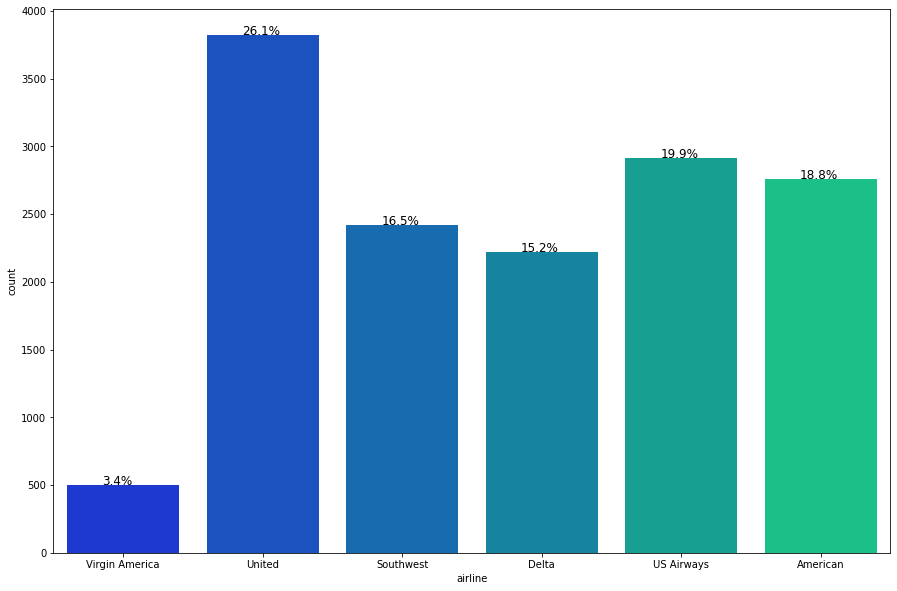

In [ ]:
# distribution of all tweets among airline
plt.figure(figsize=(15,10))
ax = sns.countplot(tweets['airline'],palette='winter')
perc_on_bar(ax, tweets['airline'])

**Observation** : we can see that there are more number of tweets for United  airline compared to other airlines.

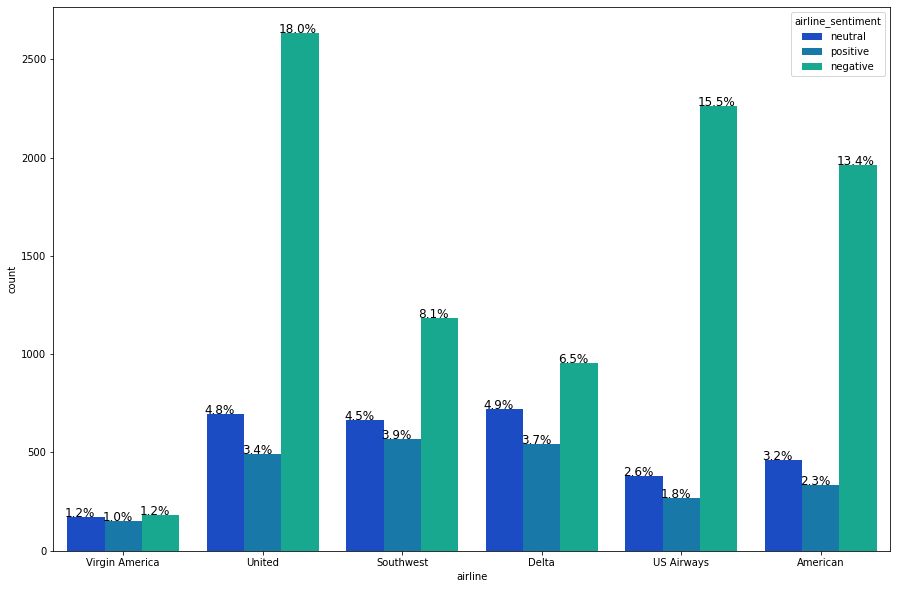

In [ ]:
# distribution of Sentiment of tweets for each airline
plt.figure(figsize=(15,10))
ax = sns.countplot(tweets['airline'],palette='winter',hue=tweets['airline_sentiment'])
perc_on_bar(ax, tweets['airline'])

**Observation:** Airlines United, US Airways, American has more number of Negative tweets.

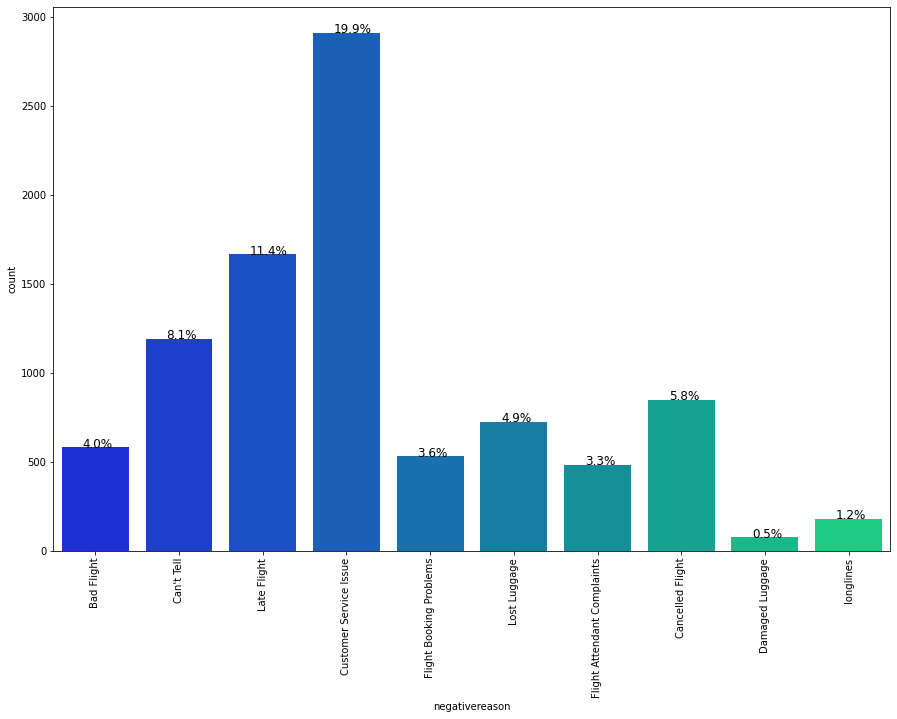

In [ ]:
# plot the distribution of all the negative reasons.
negative_reasons = tweets[~tweets['negativereason'].isnull()]
plt.figure(figsize=(15,10))
plt.xticks(rotation = 90)
ax = sns.countplot(tweets['negativereason'],palette='winter')
perc_on_bar(ax, tweets['negativereason'])

**Observation:** Most of the negative reasons are related to customer service issues.

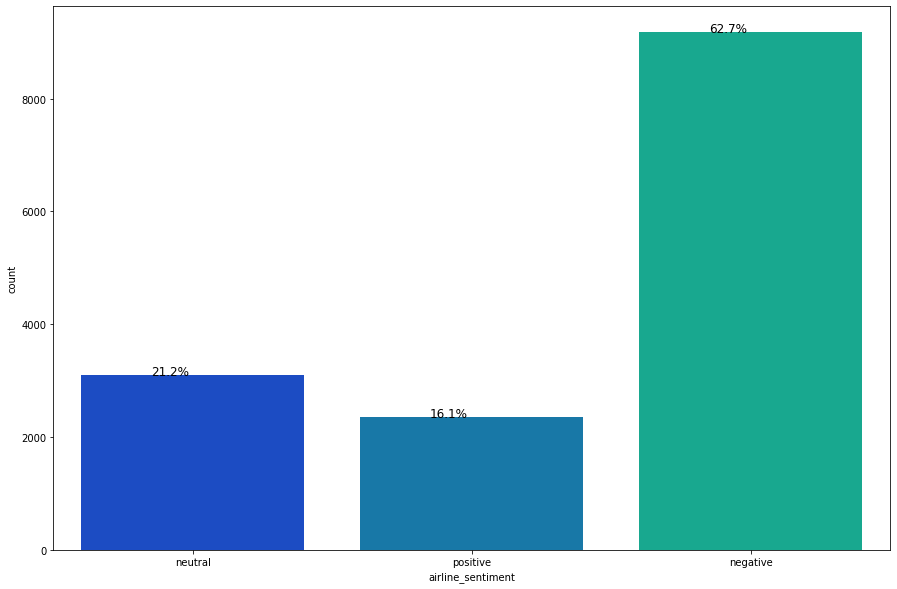

In [ ]:
# check the aire line sentiment distribution across all the tweets
# distribution of Sentiment of tweets for each airline
plt.figure(figsize=(15,10))
ax = sns.countplot(tweets['airline_sentiment'],palette='winter')
perc_on_bar(ax, tweets['airline_sentiment'])

**Observation:** Majority of the tweets are Negative which are almost 63%.

In [ ]:
# Plot the word cloud graph of tweets for positive and negative sentiment separately.
positive_sentiment = tweets[tweets['airline_sentiment']=='positive']
negative_sentiment = tweets[tweets['airline_sentiment']=='negative']

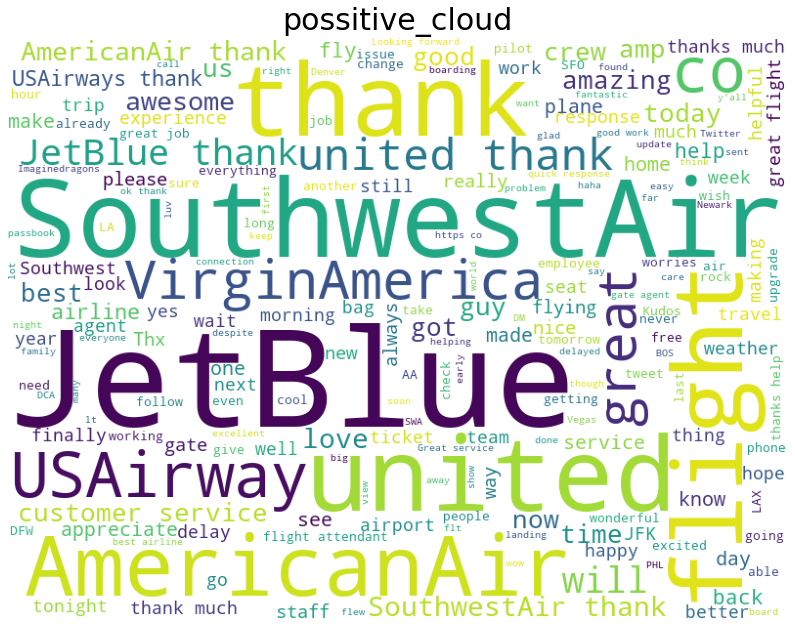

In [ ]:
# positive sentiment cloud
show_wordcloud(positive_sentiment,'possitive_cloud')

*Words like "SouthwestAir", "JetBlue", "Flight","United","thank", "love", "great","crew","helpful","happy","today" highlighted in this positive sentiment.*

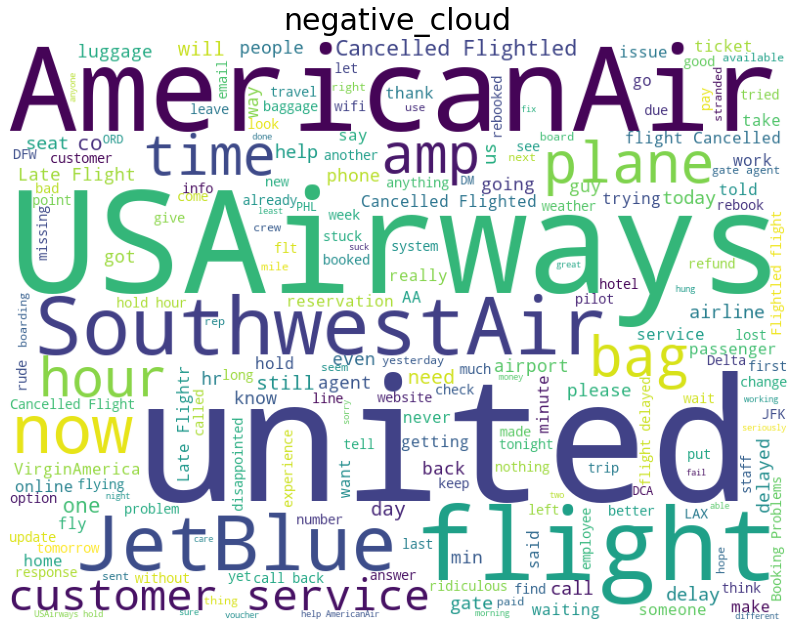

In [ ]:
# word cloud for negative sentiment
show_wordcloud(negative_sentiment,'negative_cloud')

*Words like "American Air", USAirways", "southwest Air","customer service", "hour", "united", "jetblue", "plane", "now" are highlighted.*

### **Drop the columns**

In [ ]:
# Droping all the columns except airline sentiment and text
data = tweets.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis=1)
print(data.shape) # check shape of the data

(14640, 2)


In [ ]:
# print first 5 records.
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


### **Text pre-processing: Data preparation.**

* Html tag removal.
* Tokenization.
* Remove the numbers.
* Removal of Special Characters and Punctuations.
* Removal of stopwords
* Conversion to lowercase.
* Lemmatize or stemming.
* Join the words in the list to convert back to text string in the data frame.(So that each row contains the data in text format.)



In [ ]:
# HTML tag removal
# function for HTML tag removal
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

data['text'] = data['text'].apply(lambda x : strip_html(x))
data.head()
# 

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [ ]:
# remove contractions
# function for replace contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)
data['text'] = data['text'].apply(lambda x: replace_contractions(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you have added commercials...
2,neutral,@VirginAmerica I did not today... Must mean I ...
3,negative,@VirginAmerica it is really aggressive to blas...
4,negative,@VirginAmerica and it is a really big bad thin...


In [ ]:
# common function for Removal of Special Characters and Punctuations
def removal_specialchars_punctuations(text):
  special_chars = re.escape(string.punctuation) # get all the possible list of special chars
  text = re.sub(r'['+special_chars+']','',text) # replaing special chars
  text = re.sub(r'[^\w\s]','',text) # replace the punctuations
  return text

data['text'] = data['text'].apply(lambda x : removal_specialchars_punctuations(x))
data.head()

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you have added commercials ...
2,neutral,VirginAmerica I did not today Must mean I need...
3,negative,VirginAmerica it is really aggressive to blast...
4,negative,VirginAmerica and it is a really big bad thing...


In [ ]:
# removal of numbers
def removal_numbers(text):
  text = re.sub(r'[\d]','',text)
  return text

data['text'] = data['text'].apply(lambda x: removal_numbers(x))
data.head()

,airline_sentiment,text
0,neutral,VirginAmerica What dhepburn said
1,positive,VirginAmerica plus you have added commercials ...
2,neutral,VirginAmerica I did not today Must mean I need...
3,negative,VirginAmerica it is really aggressive to blast...
4,negative,VirginAmerica and it is a really big bad thing...


In [ ]:
# tokenization
data['text']= data['text'].apply(lambda x: nltk.word_tokenize(x))
data.head()

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, you, have, added, commer..."
2,neutral,"[VirginAmerica, I, did, not, today, Must, mean..."
3,negative,"[VirginAmerica, it, is, really, aggressive, to..."
4,negative,"[VirginAmerica, and, it, is, a, really, big, b..."


In [ ]:
# removal of any non ascii chars
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words
data['text'] = data['text'].apply(lambda x : remove_non_ascii(x))
data.head()

,airline_sentiment,text
0,neutral,"[VirginAmerica, What, dhepburn, said]"
1,positive,"[VirginAmerica, plus, you, have, added, commer..."
2,neutral,"[VirginAmerica, I, did, not, today, Must, mean..."
3,negative,"[VirginAmerica, it, is, really, aggressive, to..."
4,negative,"[VirginAmerica, and, it, is, a, really, big, b..."


In [ ]:
# convert all the text to lower case
def to_lowercase(text):
  new_text = []
  for word in text:
    new_text.append(word.lower())
  return new_text

data['text'] = data['text'].apply(lambda x : to_lowercase(x))
data.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, you, have, added, commer..."
2,neutral,"[virginamerica, i, did, not, today, must, mean..."
3,negative,"[virginamerica, it, is, really, aggressive, to..."
4,negative,"[virginamerica, and, it, is, a, really, big, b..."


In [ ]:
# remove stopwords
stopwords = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stopwords = list(set(stopwords) - set(customlist))

def remove_stopwords(text):
  new_words = []
  for word in text:
    if word not in stopwords:
      new_words.append(word)
  return new_words

data['text'] = data['text'].apply(lambda x: remove_stopwords(x))
data.head()
  

,airline_sentiment,text
0,neutral,"[virginamerica, dhepburn, said]"
1,positive,"[virginamerica, plus, added, commercials, expe..."
2,neutral,"[virginamerica, not, today, must, mean, need, ..."
3,negative,"[virginamerica, really, aggressive, blast, obn..."
4,negative,"[virginamerica, really, big, bad, thing]"


In [ ]:
# lemmatize list of words and join them
lemmatizer = WordNetLemmatizer()
def lemmatize_words(words):
  new_words = []
  for word in words:
    new_words.append(lemmatizer.lemmatize(word,pos='v'))
  return ' '.join(new_words)

data['text'] = data['text'].apply(lambda x : lemmatize_words(x))
data.head() # check data after Text pre processing 

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience ...
2,neutral,virginamerica not today must mean need take an...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


### **Vectorization**

**CountVectorizer -data features**

In [ ]:
count_vector = CountVectorizer(max_features=2000)  
count_vector_data_features = count_vector.fit_transform(data['text'])
# convert to array 
count_vector_data_features = count_vector_data_features.toarray()
print(count_vector_data_features.shape)

(14640, 2000)


**TF-IDF Vectorizer - data features**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
tfidf_vectorizer_data_features = tfidf_vectorizer.fit_transform(data['text'])
# convert to array 
tfidf_vectorizer_data_features = tfidf_vectorizer_data_features.toarray()
print(tfidf_vectorizer_data_features.shape)

(14640, 2000)


In [ ]:
#map the airline sentiment to integer values
labels = {"neutral": 0,
          "positive": 1,
          "negative" : 2}
y = data['airline_sentiment'].map(labels)

### **Build the Model with both vectorizers.**

**Model building with CountVectorizer & Random Forest**

Split data into training and testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(count_vector_data_features, y, test_size=0.3, random_state=42)

In [ ]:
# build random Forest model
rf = RandomForestClassifier(n_estimators=10, n_jobs=4)
rf.fit(X_train, y_train)
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


[[ 402   66  416]
 [ 108  391  195]
 [ 201   66 2547]]
0.7604735883424408


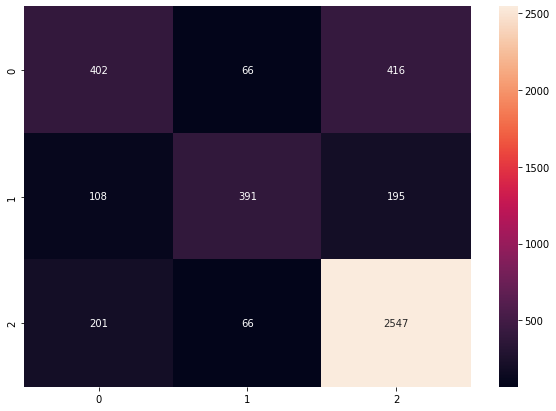

In [ ]:
result =  rf.predict(X_test)

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

print(metrics.accuracy_score(y_test,result))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Basic randomforest model with CountVector  has accuracy score 76%

In [ ]:
# check cross validation score
cv_score = np.mean(cross_val_score(rf, count_vector_data_features, y, cv=5))
print('cross validation score. = {}'.format(cv_score))

cross validation score. = 0.6782103825136611


Hyper tune the model

In [ ]:
rf_tuned = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": np.arange(10, 110, 10),
    "min_samples_leaf": np.arange(1,15,5),
    "min_samples_split": np.arange(2, 20, 5),
    "max_features":['auto', 'sqrt'],
    "max_depth": list(np.arange(5,30,5)) + [None],
    "bootstrap": [True, False]
}

#Calling RandomizedSearchCV
random_cv = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, random_state=42)

#Fitting parameters in RandomizedSearchCV
random_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_cv.best_params_,random_cv.best_score_))


Best parameters are {'n_estimators': 100, 'min_samples_split': 12, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False} with CV score=0.7601484602840173:


In [ ]:
# build the model with best parametrers
rf_tuned = RandomForestClassifier(n_estimators=100,min_samples_split=12,min_samples_leaf=1,max_features='auto',max_depth=None,bootstrap=False)
rf_tuned.fit(X_train, y_train)
print(rf_tuned)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
# cross validation score on hyper tuned random forest
cv_score = np.mean(cross_val_score(rf_tuned, count_vector_data_features, y, cv=5))
print('cross validation score. = {}'.format(cv_score))

cross validation score. = 0.7003415300546448


[[ 414   68  402]
 [  92  408  194]
 [ 153   58 2603]]
0.7798269581056466


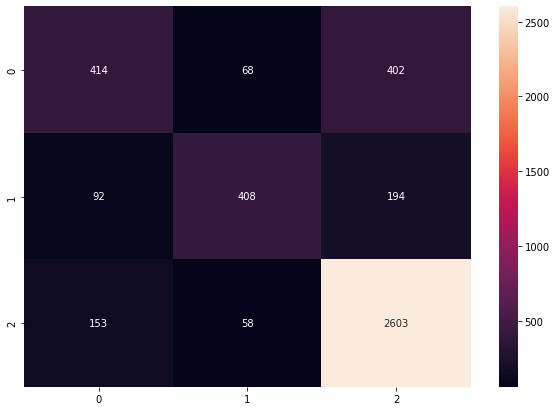

In [ ]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
result =  rf_tuned.predict(X_test)

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

print(metrics.accuracy_score(y_test,result))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

###### Observation 
- With hyper parameter tuning technique the Model accuracy score increased from 76% to 78%

##### **Word Cloud of top 40 important features from the CountVectorizer + Random Forest based model**

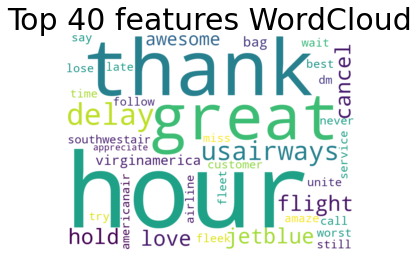

In [ ]:
all_features = count_vector.get_feature_names()                                #Instantiate the feature from the vectorizer
Top_features=''                                                              #Addition of top 40 feature into top_feature after training the model
feat=rf_tuned.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    Top_features+=all_features[i]
    Top_features+=' '
    
  
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="White",width=1000, 
                          height=750).generate(Top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(30, 30), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=30)
plt.axis("off")
plt.show()

**Build model TF-IDF & RandomForest**

Split data into training and testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectorizer_data_features, y, test_size=0.3, random_state=42)

In [ ]:
# build basic random Forest model 
rf1 = RandomForestClassifier(n_estimators=10, n_jobs=4)
rf1.fit(X_train, y_train)
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


In [ ]:
# check cross validation score
cv_score = np.mean(cross_val_score(rf1, count_vector_data_features, y, cv=5))
print('cross validation score. = {}'.format(cv_score))

cross validation score. = 0.6864071038251367


[[ 392   70  422]
 [  98  376  220]
 [ 187   69 2558]]
0.7572859744990893


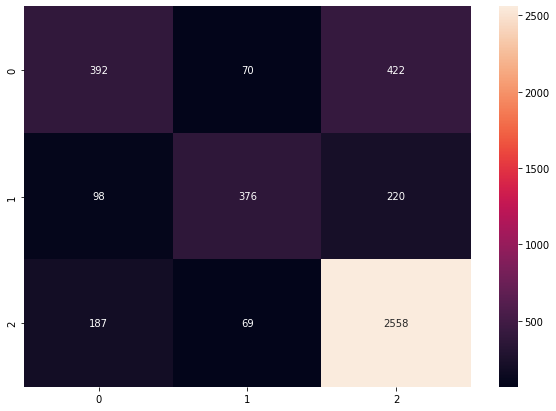

In [ ]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
result =  rf1.predict(X_test)

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

print(metrics.accuracy_score(y_test,result))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

Basic Randomforest model with TF-IDF vector has 75% accuracy score.

Hyper tune the Model

In [ ]:
rf_tuned = RandomForestClassifier(random_state=42)
param_grid = {
    "n_estimators": np.arange(10, 110, 10),
    "min_samples_leaf": np.arange(1,15,5),
    "min_samples_split": np.arange(2, 20, 5),
    "max_features":['auto', 'sqrt'],
    "max_depth": list(np.arange(5,30,5)) + [None],
    "bootstrap": [True, False]
}

#Calling RandomizedSearchCV
random_cv_td_idf = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param_grid, n_iter=50, scoring='accuracy', cv=5, random_state=42)

#Fitting parameters in RandomizedSearchCV
random_cv_td_idf.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(random_cv_td_idf.best_params_,random_cv_td_idf.best_score_))

Best parameters are {'n_estimators': 50, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': False} with CV score=0.7555618088538133:


In [ ]:
# build the model with best parametrers
random_cv_td_idf = RandomForestClassifier(n_estimators=50,min_samples_split=7,min_samples_leaf=1,max_features='sqrt',max_depth=None,bootstrap=False)
random_cv_td_idf.fit(X_train, y_train)
print(random_cv_td_idf)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [ ]:
# cross validation score on hyper tuned random forest
cv_score = np.mean(cross_val_score(random_cv_td_idf, tfidf_vectorizer_data_features, y, cv=5))
print('cross validation score. = {}'.format(cv_score))

cross validation score. = 0.7007513661202186


[[ 386   70  428]
 [  92  404  198]
 [ 143   48 2623]]
0.7770947176684881


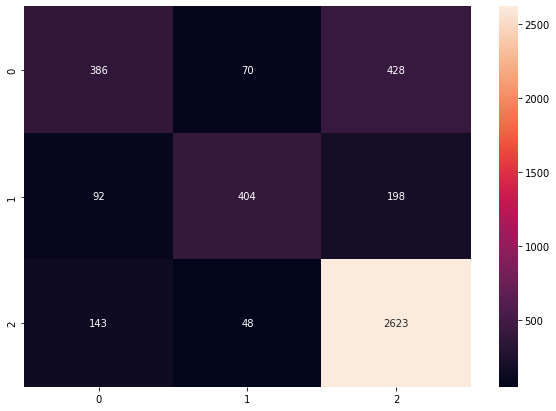

In [ ]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
result =  random_cv_td_idf.predict(X_test)

conf_mat = confusion_matrix(y_test, result)

print(conf_mat)

print(metrics.accuracy_score(y_test,result))

df_cm = pd.DataFrame(conf_mat, index = [i for i in "012"],
                  columns = [i for i in "012"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

##### obsevation:
hyper parameter tuning increased model accuracy score from 75% to 77%

**Word Cloud of top 40 important features from the CountVectorizer + Random Forest based model**

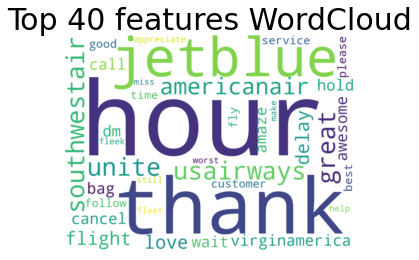

In [ ]:
all_features = tfidf_vectorizer.get_feature_names()                                #Instantiate the feature from the vectorizer
Top_features=''                                                              #Addition of top 40 feature into top_feature after training the model
feat=random_cv_td_idf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    Top_features+=all_features[i]
    Top_features+=' '
    
  
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="White",width=1000, 
                          height=750).generate(Top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(30, 30), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=30)
plt.axis("off")
plt.show()

### **Conclusion**
###### EDA analysis: 
- we can see that there are more number of tweets for United  airline compared to other airlines.
- Airlines : United, US Airways, American has more number of Negative tweets.
- Most of the negative reasons are related to customer service issues.
- Majority of the tweets are Negative which are almost 63%. 

##### Text Preprocessing :
- Applied various preprocessing techniques like removal of special chars, removal of numbers, removal of non ascii chars,
removal of HTML tags,removal of punctuations, tokenization, converting to lower case & Lemmatize . And joined back all the words to string for further processing of vectorization.
- Applied vectorization methods 'countVector, TF-IDF vectors'  on processed data above.

###### Model building and performance tuning: 
- Basic Random forest model was built seperately on each type of vectorized data features.
- Accuracy score for each model:
  - random forest with CountVector-76%.
  - randomforest with TF-IDF - 75%.
- Applied hyper parameter tuning technique random search CV on each models. Accuracy score is slightly increased.
  - Hyper tuned random forest with CountVector-78%
  - Hyper tuned randomforest with TF-IDF - 77%.

Note : I was trying to apply grid search cv as well. Due to execution time contraint I performed random search CV alone.